# Homework #2: Music Auto Tagging (Multi-Label Classification)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems. 

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

# Getting Ready

## Preparing The Dataset
We use the [magnatagatune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) dataset which has been the most widely used in the music tagging task.  The MagnaTagATune dataset consists of 25k music
clips from 6,622 unique songs.

The dataset contains 30-second audio files including 189 different tags
For this homework, we are going to use a magnatagatune with 8-second audio and only 50 genres.

We use subset of magnatagatune dataset (9074 samples x 8 sec).

To make your life easier, place them in a directory as below:

```
├── annotations_final.csv
├── waveform
  ├── 1
  ├── ...
  └── d
```

In [1]:
# Download the dataset (3GB)
#!wget http://mi.soi.city.ac.uk/datasets/magnatagatune/annotations_final.csv
#!gdown --id 1f_kUF9nTLFI0pJaZxm6YNt4t_J6-Q-dg

In [2]:
#%%capture
#!tar -xvf gct634.tar.gz

## Importing Packages

In [3]:
import warnings
import multiprocessing
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import os
import torchaudio
import torch
import torch.nn as nn
from sklearn import metrics

from tqdm.notebook import tqdm
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import IPython.display as ipd

## Enabling and testing the GPU

First, you'll need to enable GPUs for the Colab notebook:

- Navigate to Edit (수정) → Notebook Settings (노트 설정)
- select GPU from the Hardware Accelerator (하드웨어 가속기) drop-down

Next, we'll confirm that we can connect to the GPU with PyTorch and check versions of packages:

In [4]:
if not torch.cuda.is_available():
  raise SystemError('GPU device not found!')
print(f'Found GPU at: {torch.cuda.get_device_name()}')
print(f'PyTorch version: {torch.__version__}')
print(f'Torch Audio version: {torchaudio.__version__}')

Found GPU at: NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version: 1.12.1
Torch Audio version: 0.12.1


If the cell above throws an error, then you should enable the GPU following the instruction above!

# Data Checking


In [5]:
# use 50 top tags
TAGS = ['guitar','classical', 'slow','techno','strings','drums','electronic','rock',
        'fast','piano','ambient','beat','violin','vocal','synth','female','indian',
        'opera','male','singing','vocals','no vocals','harpsichord','loud','quiet',
        'flute', 'woman', 'male vocal', 'no vocal', 'pop','soft','sitar', 'solo',
        'man', 'classic', 'choir', 'voice', 'new age', 'dance', 'male voice',
        'female vocal', 'beats', 'harp', 'cello', 'no voice', 'weird', 'country',
        'metal', 'female voice', 'choral']

In [6]:
df = pd.read_csv("./annotations_final.csv", sep="\t", index_col=0)
item = df.iloc[0]
item[item != 0] # check annotated tags

classical                                                    1
strings                                                      1
opera                                                        1
violin                                                       1
mp3_path     f/american_bach_soloists-j_s__bach_solo_cantat...
Name: 2, dtype: object

In [7]:
# filter out, un-annnotated dataset
df_filter =  df[TAGS].sum(axis=1)
use_id = df_filter[df_filter != 0].index
df = df.loc[use_id]

<AxesSubplot: >

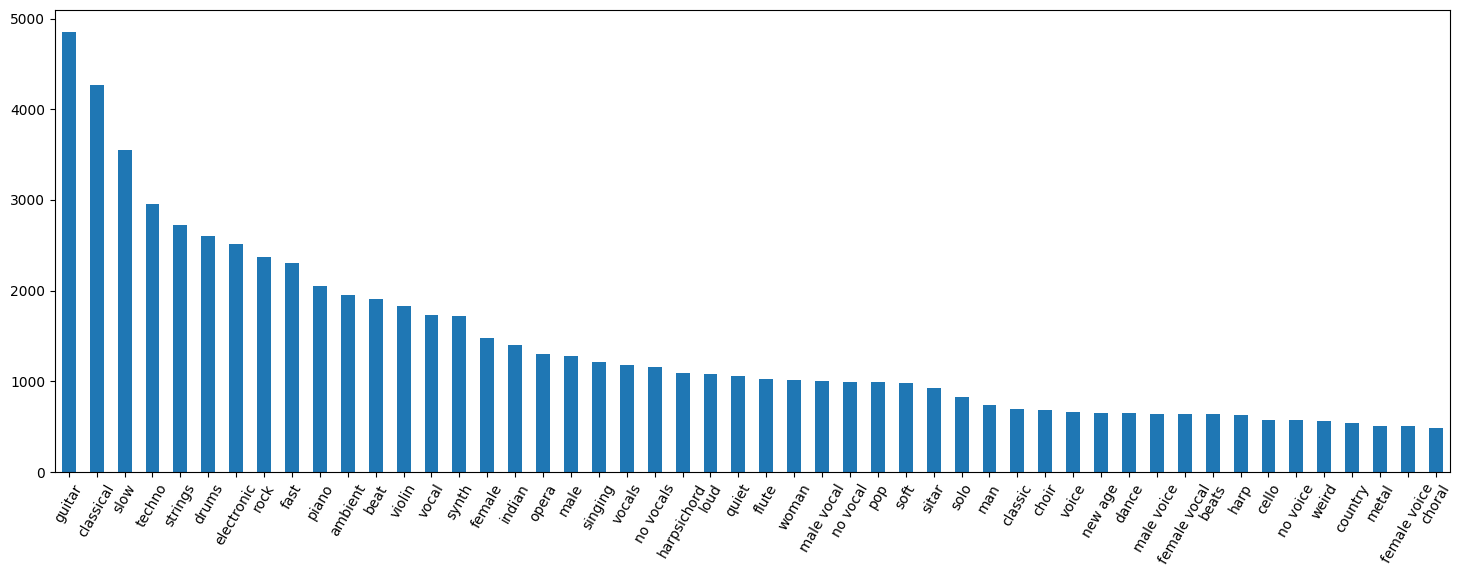

In [8]:
df[TAGS].sum().plot.bar(figsize=(18,6),rot=60) # check data distribution

In [9]:
len(df)

21111

In [10]:
sample_item = df.loc[54327] # sample id
waveform = np.load(os.path.join("./waveform",sample_item['mp3_path'].replace(".mp3",".npy")))
print("annotation tag: ",list(sample_item[sample_item == 1].index))
ipd.Audio(waveform, rate=16000) # load a NumPy array

annotation tag:  ['classical', 'guitar', 'solo', 'strings', 'classical guitar', 'spanish', 'slow']


# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [11]:
train = []
valid = []
test = []
id_to_path = {}
for idx in range(len(df)):
  item = df.iloc[idx]
  id = item.name
  path = item['mp3_path']
  folder = path.split("/")[0]
  id_to_path[id] = path
  if folder in "012ab":
    train.append(id)# split = "train"
  elif folder == "c":    
    valid.append(id)# split = "valid"
  elif folder in "d":
    test.append(id)# split = "test"

In [12]:
total = len(train) + len(valid) + len(test)
total, len(train) / total, len(valid)/ total, len(test)/ total

(9074, 0.6839321137315406, 0.16850341635441923, 0.14756446991404013)

In [13]:
df = df[TAGS]

In [14]:
df_train = df.loc[train]
df_valid = df.loc[valid]
df_test = df.loc[test]

In [15]:
# Data processing setup.
SR = 16000
BATCH_SIZE = 16

## Dataset & DataLoader

In [16]:
import AudioDataset

### Computing statistics of the training set
The code below compute mean, standard deviation and the minimum temporal dimension size, and use them for preprocessing inputs.

In [17]:
BATCH_SIZE = 16
num_workers = 2
sample_rate = 16000
duration = 3
input_length =  sample_rate * duration
data_path = "./waveform"
tr_data = AudioDataset.AudioDataset(data_path, input_length, df_train, id_to_path, 'TRAIN')
va_data = AudioDataset.AudioDataset(data_path, input_length, df_valid, id_to_path, 'VALID')
te_data = AudioDataset.AudioDataset(data_path, input_length, df_test, id_to_path, 'TEST')
loader_train = DataLoader(tr_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = DataLoader(va_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(te_data, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

## Training a baseline
The table below shows the architecture of the baseline.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x 16000 * sec,    | batch x channel x samples |
| mel_spec       | B x 96 x 188    | batch x freq x time|
| conv + maxpool | B x 32 x 64    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 22    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 8     | kernel_size=3 stride=1 |
| global_avgpool | B x 32 x 1     | -                       |
| classifier     | B x 50         | -                       |

The class below is an implementation of it:

In [18]:
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self,
                sample_rate=16000,
                n_fft=512,
                f_min=0.0,
                f_max=8000.0,
                n_mels=96,
                n_class=50):
        super(Baseline, self).__init__()
        
        # Spectrogram
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                         n_fft=n_fft,
                                                         f_min=f_min,
                                                         f_max=f_max,
                                                         n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)
        
        self.conv0 = nn.Sequential(
            nn.Conv1d(n_mels, out_channels=32, kernel_size=3, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3)
            )

        self.conv1 = nn.Sequential(
            nn.Conv1d(32, out_channels=32, kernel_size=3, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3)
            )

        self.conv2 = nn.Sequential(
            nn.Conv1d(32, out_channels=32, kernel_size=3, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3)
            )
        # Aggregate features over temporal dimension.
        self.final_pool = nn.AdaptiveAvgPool1d(1)
        # Predict tag using the aggregated features.
        self.linear = nn.Linear(32, n_class)

    def forward(self, x):
        x = self.spec(x)
        x = self.to_db(x)
        x = self.spec_bn(x)
        x = x.squeeze(1) # for 1D conv
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.final_pool(x)
        x = self.linear(x.squeeze(-1))
        x = nn.Sigmoid()(x) # for binary cross entropy loss
        return x

In [19]:
class Runner(object):
  def __init__(self, model, lr, momentum, weight_decay, sr, tags):
    self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=5, verbose=True)
    self.learning_rate = lr
    self.stopping_rate = sr
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model = model.to(self.device)
    self.criterion = torch.nn.BCELoss().to(self.device)
    self.tags = tags

  # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
  def run(self, dataloader, epoch, mode='TRAIN'):
    self.model.train() if mode is 'TRAIN' else self.model.eval()

    epoch_loss = 0
    pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
    for x, y in pbar:
      # Move mini-batch to the desired device.
      x = x.to(self.device)
      y = y.to(self.device)
      # Feed forward the model.
      prediction = self.model(x)
      # Compute the loss.
      loss = self.criterion(prediction, y)
      if mode is 'TRAIN':
        # Perform backward propagation to compute gradients.
        loss.backward()
        # Update the parameters.
        self.optimizer.step()
        # Reset the computed gradients.
        self.optimizer.zero_grad()

      batch_size = len(x)
      epoch_loss += batch_size * loss.item()
    epoch_loss = epoch_loss / len(dataloader.dataset)
    return epoch_loss

  def test(self, dataloader):
    self.model.eval()
    epoch_loss = 0
    predictions = []
    labels = []
    pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
    for x, y in pbar:
      x = x.to(self.device)
      y = y.to(self.device)
      x = x.transpose(1,0) # pre-batch in audio loader (chunk, 1, waveform)
      prediction = self.model(x)
      prediction = prediction.mean(dim=0, keepdim=True) # average chunk audio
      loss = self.criterion(prediction, y) 
      batch_size = len(x)
      epoch_loss += batch_size * loss.item()
      predictions.extend(prediction.detach().cpu().numpy())
      labels.extend(y.detach().cpu().numpy())
    epoch_loss = epoch_loss / len(loader_test.dataset)
    roc_aucs, pr_aucs, tag_wise_rocaucs = self.get_auc(predictions, labels)
    return roc_aucs, pr_aucs, epoch_loss, tag_wise_rocaucs

  # Early stopping function for given validation loss
  def early_stop(self, loss, epoch):
    self.scheduler.step(loss, epoch)
    self.learning_rate = self.optimizer.param_groups[0]['lr']
    stop = self.learning_rate < self.stopping_rate
    return stop

  def get_auc(self, predictions, labels):
    roc_aucs = metrics.roc_auc_score(labels, predictions, average='macro')
    pr_aucs = metrics.average_precision_score(labels, predictions, average='macro')
    tag_wise_predictions = np.stack(predictions).T
    tag_wise_labels = np.stack(labels).T
    tag_wise_rocaucs = {}
    for tag, logit, label in zip(self.tags, tag_wise_predictions, tag_wise_labels):
      tag_wise_rocaucs[tag] = metrics.roc_auc_score(label, logit)
    return roc_aucs, pr_aucs, tag_wise_rocaucs

In [20]:
# Training setup.
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
MOMENTUM = 0.9
NUM_EPOCHS = 5
WEIGHT_DECAY = 0.0  # L2 regularization weight

In [21]:
# Iterate over epochs.
model = Baseline()
runner = Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR, tags=TAGS)
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(loader_train, epoch, 'TRAIN')
  valid_loss = runner.run(loader_valid, epoch, 'VALID')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break

TRAIN Epoch 00:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 00:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 1/5] [Train Loss: 0.6159] [Valid Loss: 0.5089]


TRAIN Epoch 01:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 01:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 2/5] [Train Loss: 0.4273] [Valid Loss: 0.3652]


TRAIN Epoch 02:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 02:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 3/5] [Train Loss: 0.3217] [Valid Loss: 0.2940]


TRAIN Epoch 03:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 03:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 4/5] [Train Loss: 0.2725] [Valid Loss: 0.2588]


TRAIN Epoch 04:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 04:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 5/5] [Train Loss: 0.2493] [Valid Loss: 0.2433]


In [22]:
roc_aucs, pr_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss},  roc_auc={roc_aucs}, pr_auc={pr_aucs}')

TEST:   0%|          | 0/1339 [00:00<?, ?it/s]

test_loss=0.49348619241960195,  roc_auc=0.5687790285976488, pr_auc=0.11106110708543512


<AxesSubplot: >

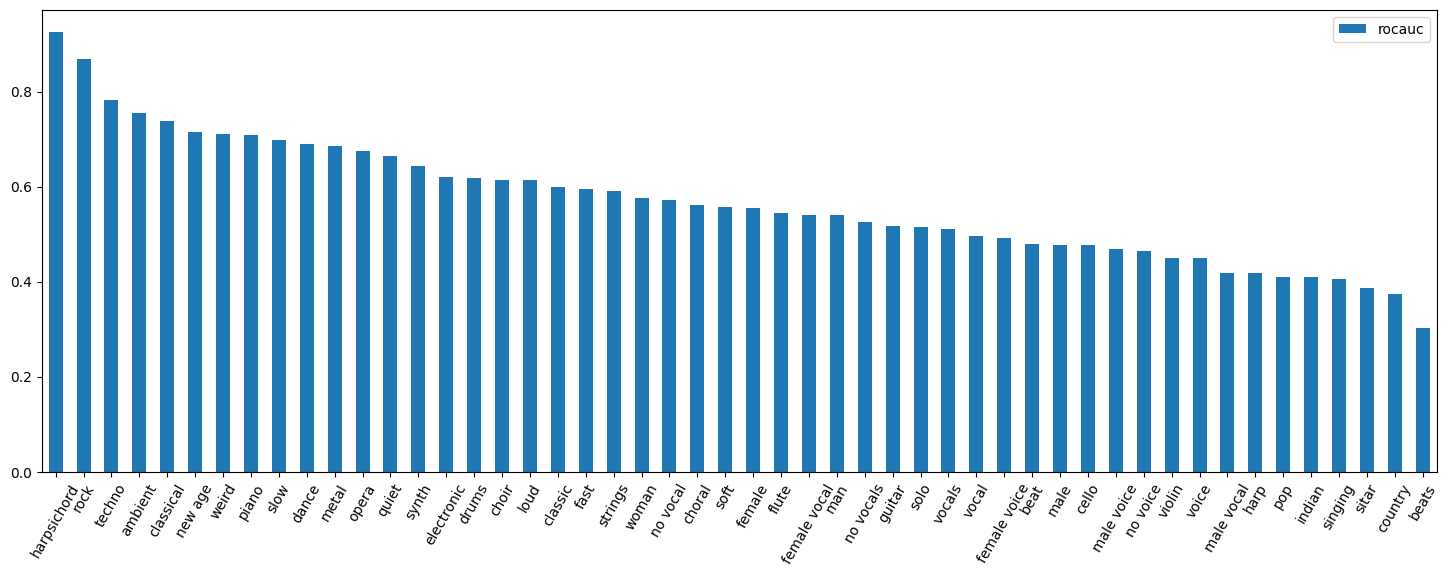

In [23]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task

In [24]:
def auto_tagging(waveform, model, input_length, tags, topk):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = model.to(device)
  chunk_number = waveform.shape[0] // input_length
  chunk = np.zeros((chunk_number, input_length))
  for idx in range(chunk.shape[0]):
    chunk[idx] = waveform[idx:idx+input_length]  
  audio_tensor = torch.from_numpy(chunk.astype(np.float32))
  predictions = model(audio_tensor.unsqueeze(1).to(device))
  logit = predictions.mean(dim=0, keepdim=False).detach().cpu().numpy()
  annotation = [tags[i] for i in logit.argsort()[::-1][:topk]]
  return annotation

In [25]:
# sample infernece id = 234
id = 224
audio_sample = df_test.loc[id]
waveform = np.load(os.path.join("./waveform",id_to_path[id].replace(".mp3",".npy")))
print("annotation tag: ",list(audio_sample[audio_sample != 0].index))
ipd.Audio(waveform, rate=16000) # load a NumPy array

annotation tag:  ['guitar', 'drums', 'rock', 'loud']


In [26]:
annotation = auto_tagging(waveform, runner.model, input_length, TAGS, 3)
print("model predict tags: ",annotation)

model predict tags:  ['guitar', 'techno', 'electronic']


### [Question 1] Implement the given architecture.
Implement a 2D CNN with the architecture below, train, and report a test accuracy of the 2D CNN.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x sample_rate * duration,    | batch x channel (mono) x samples |
| mel_spec       | B x 1 x 96 x 188    | batch x channel (mono) x freq x time|
| conv + maxpool | B x 64 x 24 x 47    | output_channels=64, kernel_size=3, pooling=(4,4) |
| conv + maxpool | B x 128 x 8 x 15    | output_channels=128, kernel_size=3, pooling=(3,3) |
| conv + maxpool | B x 128 x  2 x 5     | output_channels=128, kernel_size=3 pooling=(3,3) |
| conv + maxpool | B x 64 x 1 x 1      | output_channels=64, kernel_size=3 pooling=(2,5)                    |
| classifier     | B x 50         | -                       |


Note: you should give appropriate paddings! 

In [27]:
import torch.nn as nn

class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1, pooling=2):
        super(Conv_2d, self).__init__()
        # To do
        #========================================
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.mp = nn.MaxPool2d(pooling, stride)
        #========================================
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.mp(out)
        return out

class CNN2D(nn.Module):
    def __init__(self,
                sample_rate=16000,
                n_fft=512,
                f_min=0.0,
                f_max=8000.0,
                n_mels=96,
                n_class=50):
        super(CNN2D, self).__init__()
        
        # Spectrogram
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                         n_fft=n_fft,
                                                         f_min=f_min,
                                                         f_max=f_max,
                                                         n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)
        # To do
        #========================================
        self.layer1 = Conv_2d(1, 64, kernel_size=3, pooling=(4, 4), stride=2, padding=(3,3))
        self.layer2 = Conv_2d(64, 128, kernel_size=3, pooling=(3, 3), stride=2, padding=(6,8))
        self.layer3 = Conv_2d(128, 128, kernel_size=3, pooling=(3, 3), stride=2, padding=(2,4))
        self.layer4 = Conv_2d(128, 64, kernel_size=1, pooling=(2, 5), stride=1, padding=(0,0))
        #========================================
        self.linear = nn.Linear(64, n_class)
    def forward(self, x):
        x = self.spec(x)
        x = self.to_db(x)
        x = self.spec_bn(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = nn.Sigmoid()(x) # for binary cross entropy loss
        return x

In [28]:
# Train CNN2D
model = CNN2D()
runner = Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR, tags=TAGS)
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(loader_train, epoch, 'TRAIN')
  valid_loss = runner.run(loader_valid, epoch, 'VALID')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break

TRAIN Epoch 00:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 00:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 1/5] [Train Loss: 0.3211] [Valid Loss: 0.2249]


TRAIN Epoch 01:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 01:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 2/5] [Train Loss: 0.2188] [Valid Loss: 0.2131]


TRAIN Epoch 02:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 02:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 3/5] [Train Loss: 0.2115] [Valid Loss: 0.2081]


TRAIN Epoch 03:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 03:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 4/5] [Train Loss: 0.2074] [Valid Loss: 0.2054]


TRAIN Epoch 04:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 04:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 5/5] [Train Loss: 0.2041] [Valid Loss: 0.2028]


In [29]:
# Evaluate CNN2D
roc_aucs, pr_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss},  roc_auc={roc_aucs}, pr_auc={pr_aucs}')

TEST:   0%|          | 0/1339 [00:00<?, ?it/s]

test_loss=0.4066499556464166,  roc_auc=0.7015414878092626, pr_auc=0.18995095195994832


<AxesSubplot: >

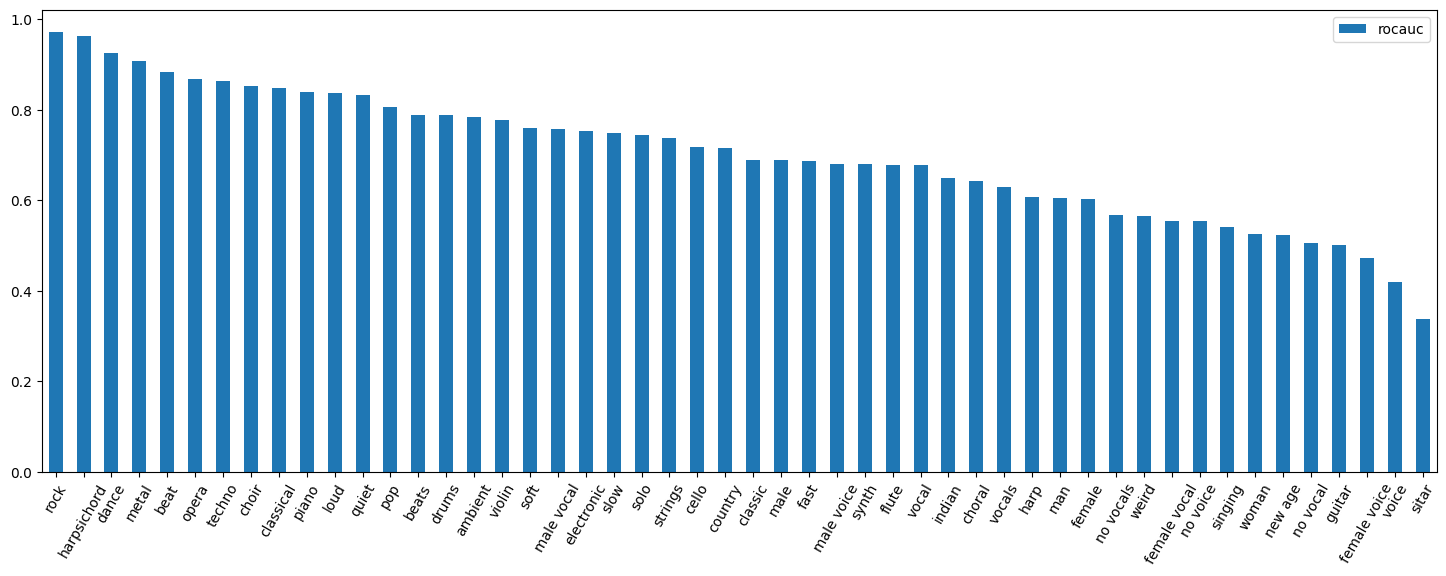

In [30]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task

### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size 
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...). 

* You can also use ResNet or other CNNs with skip connections. 

* Furthermore, you can augment data using digital audio effects.


# Deliverables
You should submit your Python code (`.ipynb` or `.py` files) and homework report (.pdf file) to KLMS. The report should include:
* Algorithm Description
* Experiments and Results
* Discussion

# Note
The code is written using PyTorch but you can use TensorFlow if you want.

# Credit
Thie homework was implemented by Jongpil Lee, Soonbeom Choi, Taejun Kim and SeungHeon Doh in the KAIST Music and Audio Computing Lab.
